In [1]:
import os
import random
import numpy as np
import math
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils




dir_path ='data'
dir_name = ['ball','dif_size','clack']
for i in dir_name:
    print(i)
    path = os.path.join(dir_path,i,'test')
    os.mkdir(path)

ball


FileExistsError: [Errno 17] File exists: 'data/ball/test'

In [2]:
def ball_points(num_points):
    points=[]
    for i in range(num_points):
        t = random.random()
        t = - np.arcsin(1-2*t)
        u = random.random() * 2 * np.pi - np.pi

        x = np.cos(t) * np.cos(u)
        y = np.cos(t) * np.sin(u)
        z = np.sin(t)
        points.append([x, y, z])
    return np.array(points)

In [3]:
def clack_rot(points):
    y = [-0.95,-0.94, -0.93, -0.92, -0.91, -0.9]
    d = [0,1,2]
    yy = random.choice(y)
    idx = random.choice(d)
    dentpoints = copy.deepcopy(points)
    dent = dentpoints[dentpoints[:,idx]<yy]
    dent[:,d[idx]] = dent[:,idx].max()
    dentpoints[dentpoints[:,idx]<yy] =dent
    
    k=random.uniform(-1,1)
    rotation = np.pi/2 + k
    c = np.cos(rotation)
    s = np.sin(rotation)
    rx = np.array([[c,-s,0],[s,c,0],[0,0,1]])
    ry = np.array([[c,0,s],[0,1,0],[-s,0,c]])
    rz = np.array([[1,0,0],[0,c,-s],[0,s,c]])
    return np.dot(np.dot(np.dot(dentpoints,rz),rx),ry)

    

In [64]:
import copy
data_num = 100
num_points = 2048
task = 'test'
dir_name = ['ball','dif_size','clack','other' ]
for i in range(data_num):
    s = random.uniform(-0.05,0.05)
    points = ball_points(num_points)
    save_path = os.path.join(dir_path,dir_name[0],task,str(i))
    np.save(save_path,points)
    
    s = random.uniform(-0.05,0.05)
    points = ball_points(num_points)
    s1 = random.uniform(-0.1,0.1)
    dif_ball = points* (1-s1)
    save_path = os.path.join(dir_path,dir_name[1],task,str(i))
    np.save(save_path,dif_ball)
    
    s = random.uniform(-0.05,0.05)
    points = ball_points(num_points)
    clack_points = clack_rot(points)
    save_path = os.path.join(dir_path,dir_name[2],task,str(i))
    np.save(save_path,dif_ball)

In [92]:
# from path import Path
path = dir_path#Path("data")



folders = [dir for dir in sorted(os.listdir(path))]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'ball': 0, 'clack': 1, 'dif_size': 2}

In [23]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud


class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)


def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])
     

In [93]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir))]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            print(root_dir,category,folder)
            new_dir = os.path.join(root_dir,category,folder)
            for file in os.listdir(new_dir):
                if file.endswith('.npy'):
                    sample = {}
                    sample['pcd_path'] = os.path.join(new_dir,file)
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud


    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = np.load(pcd_path)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [94]:

train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])
    

train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

data ball train
data clack train
data dif_size train
data ball test
data clack test
data dif_size test


In [95]:

inv_classes = {i: cat for cat, i in valid_ds.classes.items()};
inv_classes

{0: 'ball', 1: 'clack', 2: 'dif_size'}

In [104]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64, shuffle=True)

In [109]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 3):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64
    
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))

    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [110]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [111]:
pointnet = PointNet()
pointnet.to(device);

In [112]:

optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # # save the model
        # if save:
        #     torch.save(pointnet.state_dict(), "save_"+str(epoch)".pth")
     

In [113]:
train(pointnet, train_loader, valid_loader,  save=False)

[Epoch: 1, Batch:   10 /   10], loss: 0.909
Valid accuracy: 33 %
[Epoch: 2, Batch:   10 /   10], loss: 0.851
Valid accuracy: 33 %
[Epoch: 3, Batch:   10 /   10], loss: 0.728
Valid accuracy: 33 %
[Epoch: 4, Batch:   10 /   10], loss: 0.632


KeyboardInterrupt: 

In [84]:

from sklearn.metrics import confusion_matrix

In [114]:
pointnet.eval();

all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        
cm = confusion_matrix(all_labels, all_preds);
cm
     

Batch [   1 /    5]
Batch [   2 /    5]
Batch [   3 /    5]
Batch [   4 /    5]
Batch [   5 /    5]


array([[  0, 100,   0],
       [  0, 100,   0],
       [  0, 100,   0]])

In [106]:

import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
     

Normalized confusion matrix


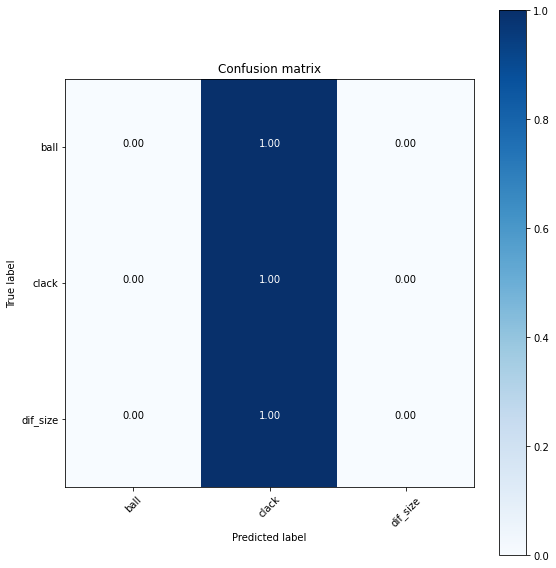

In [115]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

In [9]:
xyz = np.load("data/ball/train/0.npy")
import k3d 
plot = k3d.plot()
plot +=k3d.points(xyz[:,:3], point_size=0.01)#, attribute=scan[:,3], color_map=k3d.colormaps.basic_color_maps.Jet)
plot.display()

Output()

In [28]:
xyz = dif_ball#np.load("data/clack/train/0.npy")
import k3d 
plot = k3d.plot()
plot +=k3d.points(xyz[:,:3], point_size=0.01)#, attribute=scan[:,3], color_map=k3d.colormaps.basic_color_maps.Jet)
plot.display()
from scipy.spatial import Delaunay
import open3d as o3d
xy_catalog = []
for point in xyz:
    xy_catalog.append([point[0], point[1]])
tri = Delaunay(np.array(xy_catalog))
surface = o3d.geometry.TriangleMesh()
surface.vertices = o3d.utility.Vector3dVector(xyz)
surface.triangles = o3d.utility.Vector3iVector(tri.simplices)
# o3d.visualization.draw_geometries([surface], mesh_show_wireframe=True)
volume = reduce(lambda a, b:  a + volume_under_triangle(b), get_triangles_vertices(surface.triangles, surface.vertices), 0)
print(f"The volume of the stockpile is: {round(volume, 4)} m3")

Output()

The volume of the stockpile is: 0.777 m3


In [145]:
xyz = clack_points#np.load("data/clack/train/0.npy")
import k3d 
plot = k3d.plot()
plot +=k3d.points(xyz[:,:3], point_size=0.01)#, attribute=scan[:,3], color_map=k3d.colormaps.basic_color_maps.Jet)
plot.display()
from scipy.spatial import Delaunay
import open3d as o3d
xy_catalog = []
for point in xyz:
    xy_catalog.append([point[0], point[1]])
tri = Delaunay(np.array(xy_catalog))
surface = o3d.geometry.TriangleMesh()
surface.vertices = o3d.utility.Vector3dVector(xyz)
surface.triangles = o3d.utility.Vector3iVector(tri.simplices)
# o3d.visualization.draw_geometries([surface], mesh_show_wireframe=True)
volume = reduce(lambda a, b:  a + volume_under_triangle(b), get_triangles_vertices(surface.triangles, surface.vertices), 0)
print(f"The volume of the stockpile is: {round(volume, 4)} m3")

Output()

The volume of the stockpile is: 1.1039 m3
